In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# Dictionary to recode values (as on survey dataset)

survey_guide_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/food survey/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'
#survey_guide_path = 'insert_your_own_path/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'

# Create a dictionary of question names
questions_dict = pd.read_excel(survey_guide_path, 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# Create a nested dictionary of answer names
answers_dict = pd.read_excel(survey_guide_path, 'Values')
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}

In [4]:
# Load Food and You survey dataset

survey_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/food survey/Food+and+You+Waves+1-5+Data (3).csv'
#survey_path = 'insert_your_own_path/Food+and+You+Waves+1-5+Data (3).csv'
survey_full_dataset = pd.read_csv(survey_path)
survey_full_dataset = pd.DataFrame(survey_full_dataset)

# Encode 'Not applicable', 'Refused' and 'Don't know' as NaN
survey_full_dataset = survey_full_dataset.replace([-9, -8, -1, 98], np.nan)
cols_5_NaN = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
              'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
survey_full_dataset[cols_5_NaN] = survey_full_dataset[cols_5_NaN].replace([5], np.nan)

survey_full_dataset['age_dv_grouped'] = (survey_full_dataset['age_dv']
                                         .replace({1:'A', 2:'B', 3:'B', 4:'B', 5:'C', 6:'C', 7:'C'})
                                         .replace({'A':'16-24', 'B':'25-54', 'C':'55+'}))

survey_full_dataset.head()

,SerialNo,RespSex,age_dv,bhhsize2,below6,below16,marstat2,hhdinc,workstat2,region_dv,...,FdAuthAct_MC1,FdAuthAct_MC2,FdAuthAct_MC3,FdAuthAct_MC4,FdAuthAct_MC5,FdAuthAct_MC6,FdAuthAct_MC7,FdAuthAct_MC8,FdAuthAct_MC9,age_dv_grouped
0,100002,1,NaN,NaN,NaN,2.0,2.0,4.0,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100006,1,NaN,NaN,NaN,1.0,1.0,2.0,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100018,2,NaN,NaN,NaN,2.0,1.0,4.0,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100019,1,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100027,2,NaN,NaN,NaN,1.0,1.0,3.0,NaN,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Load census 2011 file - includes Wales and England (takes a long time to load)

census_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/2011 Census Microdata Individual Safeguarded Sample (Regional) - England and Wales/csv/microdata_census2011_wales.xlsx'
#census_path = 'insert_your_own_path/microdata_census2011_wales.xlsx'
census_full_dataset = pd.read_excel(census_path)
census_full_dataset = pd.DataFrame(census_full_dataset)

# Keep only Wales data (encoded with no 2 in the 'country' column)
census_full_dataset = census_full_dataset[census_full_dataset.country == 2]

In [21]:
# Re-structure census dataset to share colnames and values as in survey dataset

# Create new dataframe where we select only the data for demographics comparison
demographic_variables = ['age', 'marstat', 'religionew', 'sex', 'deprived', 'ecopuk', 'health']
census = census_full_dataset[demographic_variables]

# Set -9 values as NaN
census = census.replace (-9, np.nan)

# drop all rows with answers from people below 16 yo
age_out_of_range_index = census[(census['age'] < 16)].index
census.drop(age_out_of_range_index, inplace = True)

# group ages by age group 
census['age_dv'] = pd.cut(census.age, bins = [15,24,34,44,54,64,74,110], labels = [1,2,3,4,5,6,7])
# to create 3 broader age groups:
census['age_dv_grouped'] = pd.cut(census.age, bins = [15,24,54,110], labels = ['16-24','25-54','55+'])

# group marital status
census['marstat2'] = census['marstat'].replace({1:'A', 2:'B', 3:'B', 4:'A', 5:'A', 6:'A'}).replace({'B':1, 'A':2})

# group religion
census['religion_dv'] = (census['religionew']
                         .replace({1:'A', 2:'B', 3:'C', 4:'C', 5:'C', 6:'C', 7:'C', 8:'C',  9: np.nan})
                         .replace({'A':3, 'B':1, 'C':2}))

# group work status
census['workstat2'] = (census['ecopuk']
                       .replace({1:'A', 2:'A', 3:'A', 4:'A', 5:'A', 6:'A', 8:'A', 9:'A', 10:'A', 11:'A', 12:'B', 7:'C', 13:'C', 14:'C', 15:'C', 16:'C'})
                       .replace({'A':1, 'B':2, 'C':3}))

# deprivation index (reverse values)
census['wimd_2014_quintile'] = (census['deprived']
                                .replace({1:'A', 2:'B', 3:'C', 4:'D', 5:'E'})
                                .replace({'A':5, 'B':4, 'C':3, 'D':2, 'E':1}))

# health and sex
census = census.rename(columns={'health': 'Q6_1', 'sex': 'RespSex'})

# remove columns that are duplicates and not in the right format
census = census.drop(columns = ['age', 'marstat', 'religionew', 'ecopuk','deprived'])

census.head()

,RespSex,Q6_1,age_dv,age_dv_grouped,marstat2,religion_dv,workstat2,wimd_2014_quintile
154716,1,1.0,5,55+,1,1.0,1.0,5.0
154717,1,NaN,1,16-24,2,NaN,NaN,5.0
154718,1,1.0,2,25-54,2,1.0,1.0,4.0
154720,2,2.0,5,55+,1,1.0,2.0,4.0
154721,2,3.0,5,55+,2,1.0,2.0,4.0


In [23]:
# Join relevant survey data with the census data in a single dataframe

demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2', 'Q6_1', 'age_dv_grouped']

demographics_survey_and_census = survey_full_dataset[survey_full_dataset.country_dv.eq(2)] # Select Wales
demographics_survey_and_census = demographics_survey_and_census[demographic_variables]
demographics_survey_and_census['source'] = 'survey'

census['source'] = 'census'
demographics_survey_and_census = pd.concat([demographics_survey_and_census, census])

demographics_survey_and_census.head()

,age_dv,marstat2,religion_dv,RespSex,wimd_2014_quintile,workstat2,Q6_1,age_dv_grouped,source
4,NaN,1.0,1.0,2,NaN,NaN,NaN,NaN,survey
7,NaN,1.0,1.0,2,NaN,NaN,NaN,NaN,survey
23,NaN,1.0,1.0,2,NaN,NaN,NaN,NaN,survey
24,NaN,1.0,1.0,1,NaN,NaN,NaN,NaN,survey
50,NaN,1.0,1.0,2,NaN,NaN,NaN,NaN,survey


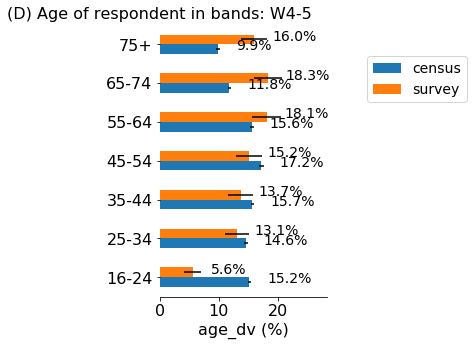

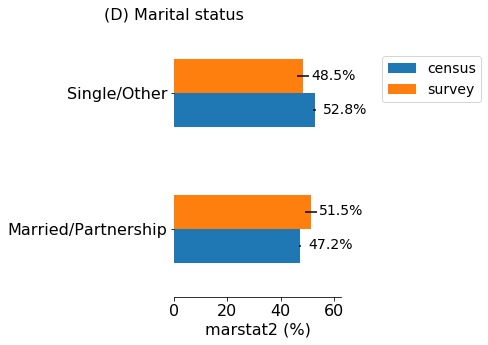

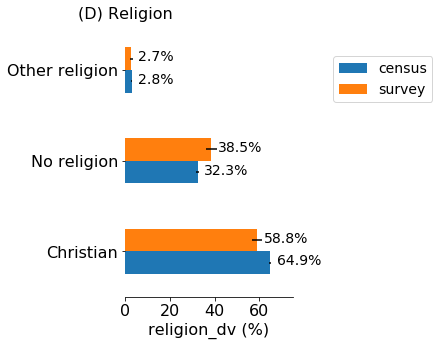

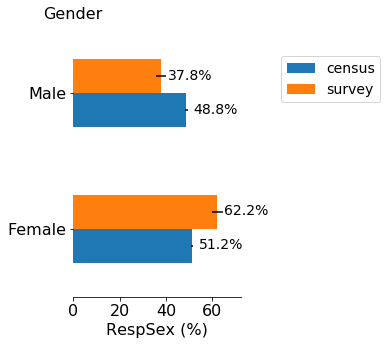

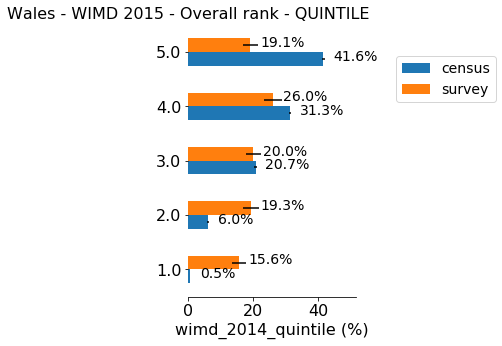

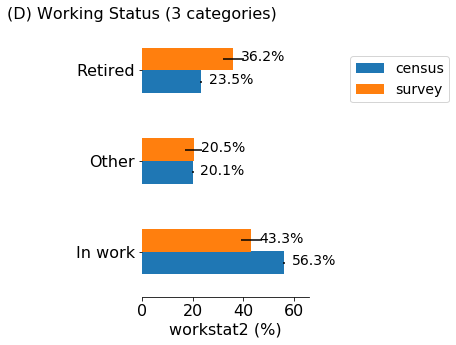

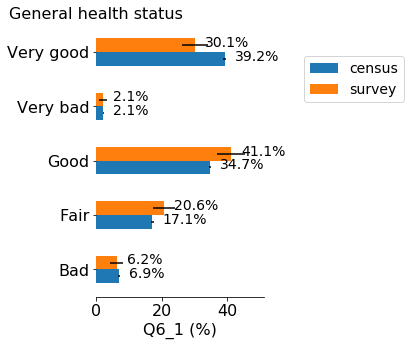

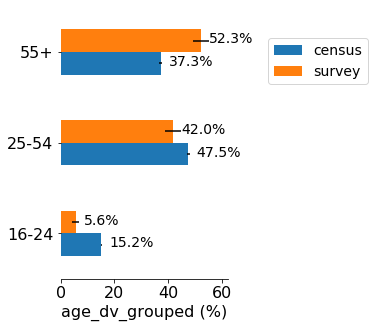

In [44]:
# Plotting demographic variables survey vs census within a for loop
# Individual .png files are saved within the same folder this notebook is saved in

for demographic_variable in demographic_variables:
    
    temp = demographics_survey_and_census.copy()
    
    # Group according to the features of interest and calculate the % of answer types for the main target feature
    temp = temp.groupby(['source', demographic_variable])[demographic_variable].agg(['count'])
    temp['total'] = temp.groupby('source')['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[demographic_variable + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp['abs_err'] = temp[demographic_variable + ' (%)'] - temp['CI_perc_lower']
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    temp

    # Recode the answers of those variables we want to use to stratify the population
    answers_to_rename = [demographic_variable]
    temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)
    
    abs_err = temp.pivot(index=demographic_variable, columns='source', values='abs_err')
   
    fig = temp.pivot(index=demographic_variable, columns='source', values=demographic_variable+' (%)')\
    .plot(kind='barh', xerr=abs_err, width=0.5, figsize=(3,5))
    for item in ([fig.title, fig.xaxis.label, fig.yaxis.label] + fig.get_xticklabels() + fig.get_yticklabels()):
        item.set_fontsize(16)
    plt.title(questions_dict.get(demographic_variable), x =0,  fontsize = 16)
    plt.xlabel(demographic_variable + ' (%)')
    plt.ylabel('')
    fig.legend(loc='center left', bbox_to_anchor=(1.2, 0.8), fontsize=14)
    plt.xlim(0, max(temp[demographic_variable +' (%)'] + 10))
    fig.spines['top'].set_visible(False)
    fig.spines['right'].set_visible(False)
    fig.spines['left'].set_visible(False)
    
    # To plot the % number
    for p in fig.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        fig.annotate('{:}%'.format(width), (x + width + 3, y + 0.1), fontsize = 14)
        # play with fontsize, depending on graph

    plt.show()
    
    fig = fig.get_figure()
    fig.savefig('survey_vs_census_' + demographic_variable + '.png', dpi=200, bbox_inches='tight')
    plt.close()


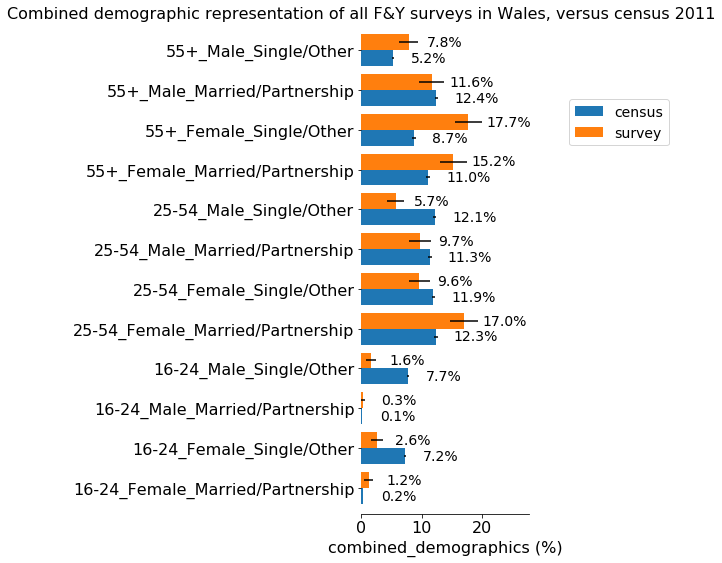

In [53]:
# Combined demographic representation of all F&Y surveys in Wales, versus census 2011

demographics_survey_and_census[demographic_variables] = demographics_survey_and_census[demographic_variables].replace(answers_dict)

demographics_survey_and_census['combined_demographics'] = (demographics_survey_and_census['age_dv_grouped'] + '_' +
                                                           demographics_survey_and_census['RespSex'] + '_' +
                                                           demographics_survey_and_census['marstat2'])
  
temp = demographics_survey_and_census.copy()
    
# Group according to the features of interest and calculate the % of answer types for the main target feature
temp = temp.groupby(['source', 'combined_demographics'])['combined_demographics'].agg(['count'])
temp['total'] = temp.groupby('source')['count'].transform('sum')
lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
temp['CI_prop_upper'] = upper
temp['CI_prop_lower'] = lower
temp['combined_demographics' + ' (%)'] = temp['count'] / temp['total'] * 100
temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
temp['abs_err'] = temp['combined_demographics' + ' (%)'] - temp['CI_perc_lower']
temp.reset_index(inplace=True) # To 'undo' the grouping
temp = temp.round(1)

abs_err = temp.pivot(index='combined_demographics', columns='source', values='abs_err')

fig = temp.pivot(index='combined_demographics', columns='source', values='combined_demographics'+' (%)')\
.plot(kind='barh', xerr=abs_err, width=0.8, figsize=(3,9))
for item in ([fig.title, fig.xaxis.label, fig.yaxis.label] + fig.get_xticklabels() + fig.get_yticklabels()):
    item.set_fontsize(16)
plt.title('Combined demographic representation of all F&Y surveys in Wales, versus census 2011', x =0,  fontsize = 16)
plt.xlabel('combined_demographics' + ' (%)')
plt.ylabel('')
fig.legend(loc='center left', bbox_to_anchor=(1.2, 0.8), fontsize=14)
plt.xlim(0, max(temp['combined_demographics' +' (%)'] + 10))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['left'].set_visible(False)

# To plot the % number
for p in fig.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    fig.annotate('{:}%'.format(width), (x + width + 3, y + 0.1), fontsize = 14)
    # play with fontsize, depending on graph

plt.show()

fig = fig.get_figure()
fig.savefig('survey_vs_census_combined-demographics.png', dpi=200, bbox_inches='tight')
plt.close()

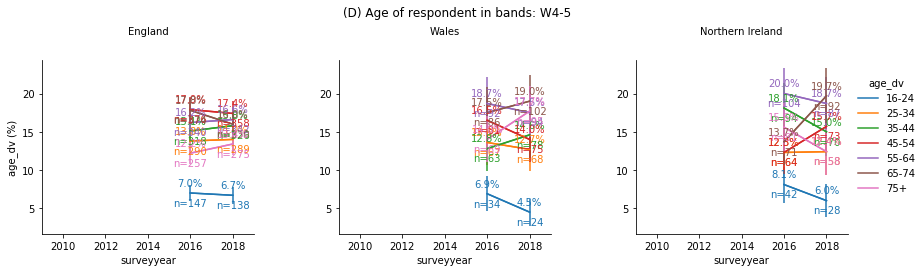

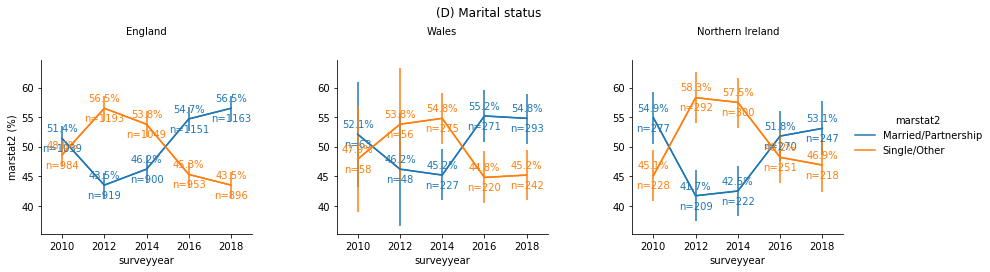

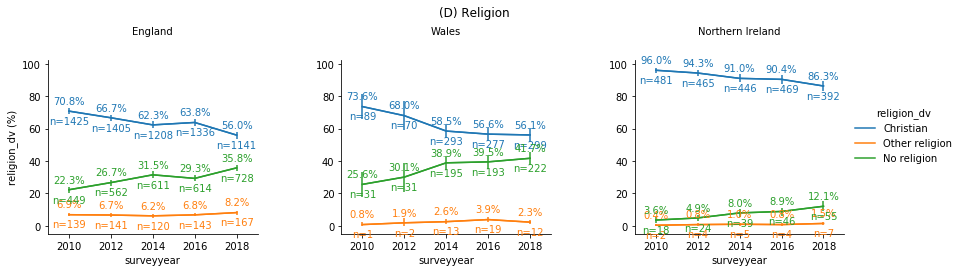

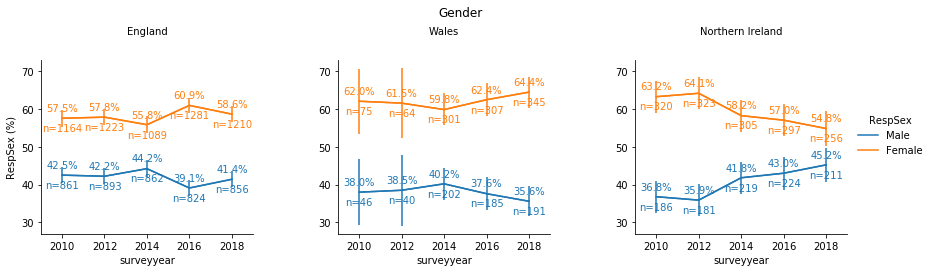

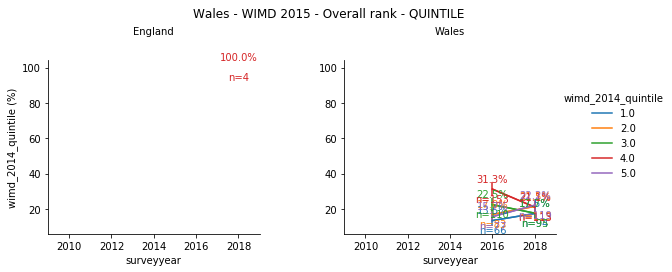

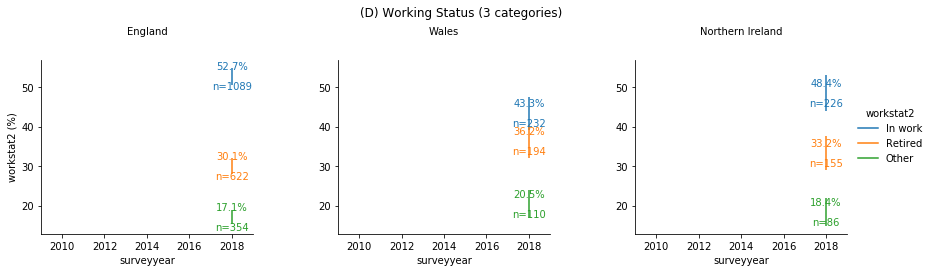

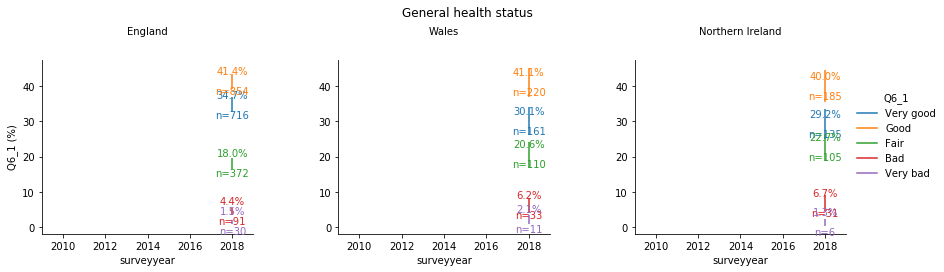

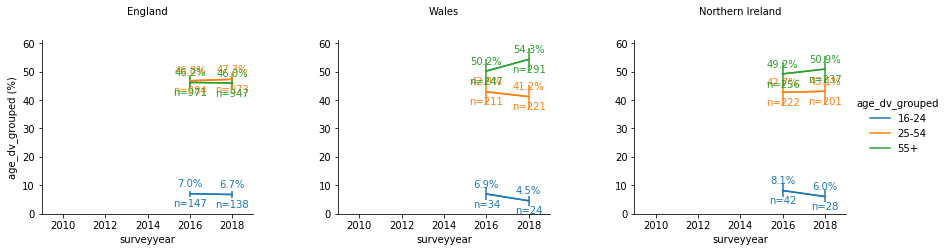

In [6]:
# Custom function for plotting.
# It specifies the % number on top and the count number below.
# It handles well preceding NaNs values (sns.pointplot doesn't handle this well)
def f(x,y,z, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]) + '%', xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')
    for i in range(len(x)):
        ax.annotate('n=' + str(z.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,-10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Define a wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

###################################

# Make faceted (per country) temporal line plots

pdf = PdfPages('demographics_FY_survey_temporal.pdf')
figures = []

for demographic_variable in demographic_variables:
    
    temp = survey_full_dataset[demographic_variables + ['country_dv','region_dv', 'surveyyear']]

    # Group according to the features of interest and calculate the % of answer types for the main target feature
    temp = temp.groupby(['country_dv','surveyyear', demographic_variable])[demographic_variable].agg(['count'])
    temp['total'] = temp.groupby(['country_dv','surveyyear'])['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[demographic_variable + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    
    # Recode the answers of those variables we want to use to stratify the population
    answers_to_rename = ['country_dv', demographic_variable, 'surveyyear']
    temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict) # pandas 1.0.3 (or newer) needed for nested replace

    # Plot features of interest from the created 'temp' subset
    g = sns.FacetGrid(temp, col='country_dv', hue=demographic_variable, height=4, aspect=1) 
    g.map(errorbar, 'surveyyear', demographic_variable + ' (%)', 'CI_perc_lower', 'CI_perc_upper')
    g = (g.map(f, 'surveyyear', demographic_variable + ' (%)', 'count')
         .add_legend())
    plt.xlim(2009, 2019)
    g.set_titles('{col_name}', pad = 25)
    plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)
    plt.figtext(.5,.9, questions_dict.get(demographic_variable), fontsize=12, ha='center')
    
    figures += [g.fig]

for figure in figures:
    pdf.savefig(figure)
pdf.close()